In [1]:
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [6]:
# LacI binding site
rep_site = 'AATTGTGAGCGGATAACAATT'

In [7]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [8]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Repressor binds much more strongly than RNAP

In [9]:
n_NS = len(genome)
n_p = 4600
n_r = 10
er_wt = -15

l_ep_wt = np.arange(-20, 0, 1)
avg_fc1 = []

for ep_wt in l_ep_wt:
    df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                            *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                            scaling_factor=10**7)

    wt_ct = df[df.seq == promoter]['norm_ct_1'].iloc[0]
    df['fc'] = df['norm_ct_1'] / wt_ct
    avg_fc1.append(np.mean(df['fc']))

In [10]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5

l_er_wt = np.arange(-25, -5, 1)
l_ep_wt = np.arange(-25, -5, 1)
avg_fc2 = []

for er_wt in l_er_wt:
    df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                            *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                            scaling_factor=10**7)

    wt_ct = df[df.seq == promoter]['norm_ct_1'].iloc[0]
    df['fc'] = df['norm_ct_1'] / wt_ct
    avg_fc2.append(np.mean(df['fc']))

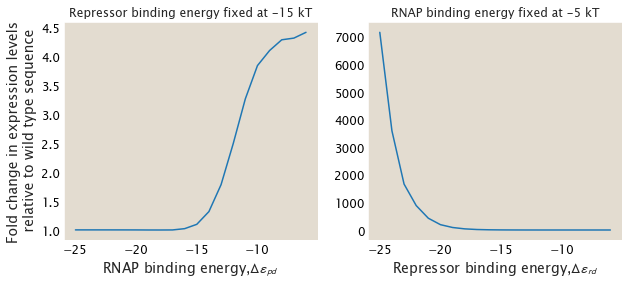

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes
ax1.plot(l_ep_wt, avg_fc1)
ax1.set_xlabel('RNAP binding energy,' + r'$\Delta \varepsilon_{pd}$', fontsize=14)
ax1.set_ylabel('Fold change in expression levels\n relative to wild type sequence', fontsize=14)
ax1.set_title('Repressor binding energy fixed at -15 kT', fontsize=12)
ax2.plot(l_er_wt, avg_fc2)
ax2.set_xlabel('Repressor binding energy,' + r'$\Delta \varepsilon_{rd}$', fontsize=14)
ax2.set_title('RNAP binding energy fixed at -5 kT', fontsize=12)
plt.savefig('../../figs/foldchange.png', dpi=300)
plt.show()

In [16]:
n_NS = len(genome)
n_p = 4600
n_r = 10
er_wt = -15

l_ep_wt = np.arange(-20, 0, 1)
signal_ratio1 = []

for ep_wt in l_ep_wt:
    l = []
    for i in range(10):
        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                scaling_factor=10**7)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        rnap_signal = (np.mean(footprint[(-38+115):(-29+115)]) + np.mean(footprint[(-15+115):(-4+115)]))/2
        rep_signal = np.mean(footprint[(2+115):(18+115)])
        l.append(rep_signal /rnap_signal)
    signal_ratio1.append(np.mean(l))

In [9]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5

l_er_wt = np.arange(-25, -5, 1)
signal_ratio2 = []

for er_wt in l_er_wt:
    l = []
    for i in range(10):
        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                scaling_factor=10**7)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        rnap_signal = (np.mean(footprint[(-38+115):(-29+115)]) + np.mean(footprint[(-15+115):(-4+115)]))/2
        rep_signal = np.mean(footprint[(2+115):(18+115)])
        l.append(rep_signal /rnap_signal)
    signal_ratio2.append(np.mean(l))

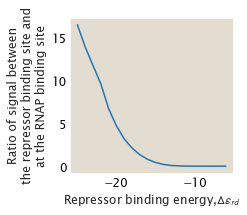

In [21]:
fig, ax = plt.subplots(figsize=(3.5, 3))
ax.plot(l_er_wt, signal_ratio2)
ax.set_xlabel('Repressor binding energy,' + r'$\Delta \varepsilon_{rd}$', fontsize=12)
ax.set_ylabel('Ratio of signal between\nthe repressor binding site and\nat the RNAP binding site', fontsize=12)
#ax.set_title('RNAP binding energy fixed at -5 kT', fontsize=12)
plt.tight_layout()
plt.savefig('../../manuscript/figures/plots/fig12/signal_ratio_simrep.png', dpi=300)
plt.show()

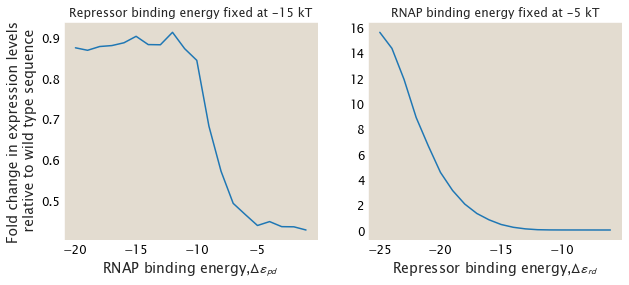

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes
ax1.plot(l_ep_wt, signal_ratio1)
ax1.set_xlabel('RNAP binding energy,' + r'$\Delta \varepsilon_{pd}$', fontsize=14)
ax1.set_ylabel('Fold change in expression levels\n relative to wild type sequence', fontsize=14)
ax1.set_title('Repressor binding energy fixed at -15 kT', fontsize=12)
ax2.plot(l_er_wt, signal_ratio2)
ax2.set_xlabel('Repressor binding energy,' + r'$\Delta \varepsilon_{rd}$', fontsize=14)
ax2.set_title('RNAP binding energy fixed at -5 kT', fontsize=12)
plt.savefig('../../figs/signal_ratio.png', dpi=300)
plt.show()

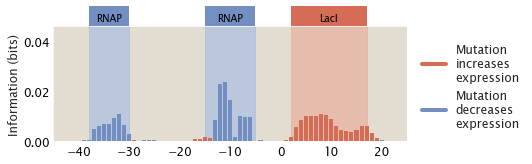

In [12]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -20
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        scaling_factor=10**7)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=8,
                               legend_xcoord=1.35,
                               annotate_stn=False,
                               max_signal=0.04,
                               outfile='../../figs/bindingenergy1.png')

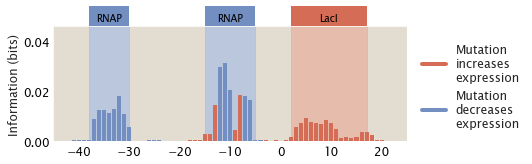

In [13]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -2
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        scaling_factor=10**7)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=8,
                               legend_xcoord=1.35,
                               annotate_stn=False,
                               max_signal=0.04,
                               outfile='../../figs/bindingenergy2.png')

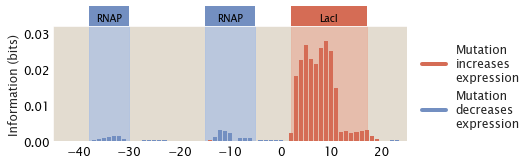

In [14]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -25

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        scaling_factor=10**7)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=8,
                               legend_xcoord=1.35,
                               annotate_stn=False,
                               outfile='../../figs/bindingenergy3.png')

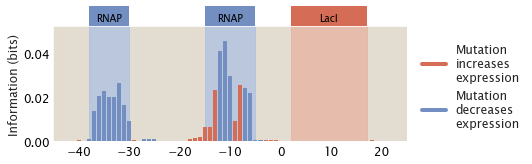

In [15]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -10

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        scaling_factor=10**7)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=8,
                               legend_xcoord=1.35,
                               annotate_stn=False,
                               outfile='../../figs/bindingenergy4.png')

### RNAP binds much more strongly than activator

In [ ]:
# CRP binding site
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

In [ ]:
# energy matrix obtained from Fig 3. of Kinney et al., 2010 (https://www.pnas.org/doi/full/10.1073/pnas.1004290107)
# elements expressed in kcal/mol (1 kcal/mol = 1.62kbT)

crp_emat_raw = pd.read_table('../../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T * 1.62

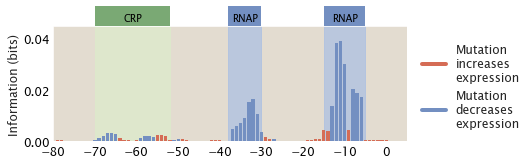

In [ ]:
## scaling down all the energy terms

n_NS = len(genome)
n_p = 4600
n_a = 50
ep_wt = -10
ea_wt = -15
e_ap = -8

df = tregs.simulate.sim(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35,
                               annotate_stn=False,
                               outfile='../../figs/weakactivator.png')

### Tuning the interaction energy between RNAP and activator

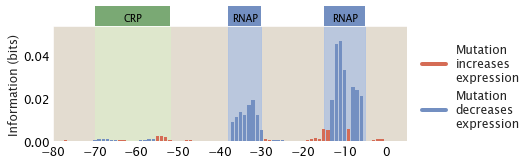

In [ ]:
# only increasing strength of RNAP-activator binding

n_NS = len(genome)
n_p = 4600
n_a = 50
ep_wt = -8
ea_wt = -12
e_ap = -10

df = tregs.simulate.sim(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35,
                               annotate_stn=False,
                               outfile='../../figs/weakinteraction.png')

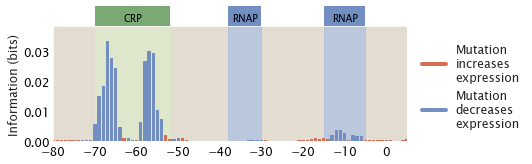

In [ ]:
# only increasing strength of RNAP-activator binding

n_NS = len(genome)
n_p = 4600
n_a = 50
ep_wt = -8
ea_wt = -20
e_ap = -10

df = tregs.simulate.sim(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35,
                               annotate_stn=False,
                               outfile='../../figs/strong interaction.png')